## Loading Dataset

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
from  scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
conn = psycopg2.connect("dbname=musicdatabase")
cur = conn.cursor()

## Creating DataFrames

In [2]:
#GENRES:
cur.execute("SELECT * FROM genres")
names = [description[0] for description in cur.description]
genres = cur.fetchall()
genres_df = pd.DataFrame(genres, columns=names)

# #ARTISTS
cur.execute("SELECT * FROM artists")
names = [description[0] for description in cur.description]
artists = cur.fetchall()
artists_df = pd.DataFrame(artists, columns=names)

# #CONTENT
cur.execute("SELECT * FROM content")
names = [description[0] for description in cur.description]
content = cur.fetchall()
content_df = pd.DataFrame(content, columns=names)

# #LABELS
cur.execute("SELECT * FROM labels")
names = [description[0] for description in cur.description]
labels = cur.fetchall()
labels_df = pd.DataFrame(labels, columns=names)

# #REVIEWS
cur.execute("SELECT * FROM reviews")
names = [description[0] for description in cur.description]
reviews = cur.fetchall()
reviews_df = pd.DataFrame(reviews, columns=names)

# #YEARS
cur.execute("SELECT * FROM years")
names = [description[0] for description in cur.description]
years = cur.fetchall()
years_df = pd.DataFrame(years, columns=names)

## Exploring the Data

In [3]:
print('genre df length: ', len(genres_df))
print('artists df length: ', len(artists_df))
print('content df length: ', len(content_df))
print('labels df length: ', len(labels_df))
print('reviews df length: ', len(reviews_df))
print('years df length: ', len(years_df))

genre df length:  22680
artists df length:  18831
content df length:  18393
labels df length:  20190
reviews df length:  18393
years df length:  19108


In [4]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18393 non-null object
artist            18393 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


In [5]:
reviews_df.isna().sum()
#no NANs in column 1.. however 2367 in column 2

reviewid             0
title                0
artist               0
url                  0
score                0
best_new_music       0
author               0
author_type       3906
pub_date             0
pub_weekday          0
pub_day              0
pub_month            0
pub_year             0
dtype: int64

## Scratch Work & More Review

In [6]:
reviews_df['author'].value_counts()
reviews_df['author'].nunique()

432

In [7]:
reviews_df['artist'].value_counts().head()

various artists     688
guided by voices     23
the beatles          21
david bowie          21
of montreal          20
Name: artist, dtype: int64

In [8]:
len(set(reviews_df['reviewid']))
#reviews_df['reviewid'].nunique()  #does the same thing

18389

## Seeing Which Tables Have Multiple Rows Per Song

In [9]:
labels_df.loc[labels_df['reviewid'] == 2626]
#example, song 6523 has 4 artists

,reviewid,label
14612,2626,cleopatra
14613,2626,alternative tentacles
14614,2626,manifesto
14615,2626,cherry red
14616,2626,irs


In [10]:
reviews_df.loc[reviews_df['reviewid']==2626]

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
13198,2626,fresh fruit for rotting vegetables,dead kennedys,http://pitchfork.com/reviews/albums/2626-fresh...,7.0,0,cory d. byrom,None,2005-11-09,2,9,11,2005


* Review Table -- has 4 songs that have 2 reviewid's... i believe this is an error as all rows are identical
* Content Table -- also has 4 songs with 2 reviewid's... will remove the duplicated rows
* Genres Tabel -- Many songs have 2+ genres
* Labels Tabel -- Many songs have 2+ labels
* Artists Tabel -- Many songs have 2+ artists
* Year Tabel -- Many songs have 2+ release years... this may be an error... considering keeping only oldest year

In [11]:
labels_df['reviewid'].value_counts().head(10)

2626     5
21550    5
21387    4
17112    4
9505     4
17920    4
16092    4
16384    4
22065    4
22567    3
Name: reviewid, dtype: int64

## Combining Genre and Review Tables

First, one hot encode genres table. 

In [12]:
# genres_df['pop/r&b'] = genres_df['genre'].apply(lambda x: 1 if x == 'pop/r&b' else 0)
# genres_df['electronic'] = genres_df['genre'].apply(lambda x: 1 if x == 'electronic' else 0)

In [13]:
genres_one_hot = pd.get_dummies(genres_df['genre'])
genres_one_hot.head()
genres_hot_df = pd.concat([genres_df, genres_one_hot], axis = 1)
genres_hot_df.head()

,reviewid,genre,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock
0,22703,electronic,1,0,0,0,0,0,0,0,0
1,22721,metal,0,0,0,0,0,1,0,0,0
2,22659,rock,0,0,0,0,0,0,0,0,1
3,22661,rock,0,0,0,0,0,0,0,0,1
4,22725,electronic,1,0,0,0,0,0,0,0,0


Second, filtered genres table for only pop & electric

In [14]:
genres_hot_df_filtered = genres_hot_df[(genres_hot_df['pop/r&b'] == 1) | (genres_hot_df['electronic'] == 1)]
genres_hot_df_filtered = genres_hot_df_filtered[['reviewid', 'electronic', 'pop/r&b']]
genres_hot_df_filtered.head()

,reviewid,electronic,pop/r&b
0,22703,1,0
4,22725,1,0
7,22694,1,0
12,22700,1,0
18,22719,0,1


Third, add value_count column in order to remove any albums that fall under both electronic & pop.

In [15]:
genre_counts = genres_hot_df_filtered['reviewid'].value_counts()
genre_dict = genre_counts.to_dict()
genres_hot_df_filtered['value_count'] = genres_hot_df_filtered['reviewid'].apply(lambda x: genre_dict[x])
genres_hot_df_filtered.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Remove albums with both electronic and pop (where value_counts = 2)

In [16]:
genre_to_drop = genres_hot_df_filtered[genres_hot_df_filtered['value_count'] == 2]
genres_df_new = genres_hot_df_filtered.drop(genre_to_drop.index, axis=0)
genres_df_new.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Merge the new Genre Table with the existing Review Table

In [17]:
#rg = review & genres
rg_df = reviews_df.merge(genres_df_new, left_on='reviewid', right_on='reviewid')
rg_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,electronic,pop/r&b,value_count
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,1,0,1
1,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,1,0,1
2,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,5,1,2017,1,0,1
3,22700,nadir,steven warwick,http://pitchfork.com/reviews/albums/22700-nadir/,7.6,0,thea ballard,contributor,2017-01-03,1,3,1,2017,1,0,1
4,22719,merry christmas lil mama,"chance the rapper, jeremih",http://pitchfork.com/reviews/albums/22719-merr...,8.1,0,sheldon pearce,associate staff writer,2016-12-30,4,30,12,2016,0,1,1


## Combining Label & Review Tables

Add value_count column to labels table to find all albums with 2+ labels. 

In [18]:
label_counts = labels_df['reviewid'].value_counts()
label_dict = label_counts.to_dict()
labels_df['value_count'] = labels_df['reviewid'].apply(lambda x: label_dict[x])
labels_df.head()

,reviewid,label,value_count
0,22703,virgin,1
1,22721,hathenter,1
2,22659,static shock,2
3,22659,fashionable idiots,2
4,22661,kill rock stars,2


Drop any rows where value_count is greater than 1 (remove any albums with 2+ labels).

In [19]:
label_to_drop = labels_df[labels_df['value_count'] > 1]
labels_df_filtered = labels_df.drop(label_to_drop.index, axis=0)
labels_df_filtered.head()

,reviewid,label,value_count
0,22703,virgin,1
1,22721,hathenter,1
6,22725,teklife,1
7,22722,rca,1
8,22704,age 101,1


In [20]:
print(len(labels_df))
print(len(labels_df_filtered))
print(labels_df_filtered['reviewid'].nunique())

20190
16761
16761


Add column to label table that specifies if the label is self-released or not. 

In [21]:
labels_df_filtered['self-released'] =  labels_df_filtered['label'].apply(lambda x: 1 if x == 'self-released' else 0)
labels_df_filtered.head()

,reviewid,label,value_count,self-released
0,22703,virgin,1,0
1,22721,hathenter,1,0
6,22725,teklife,1,0
7,22722,rca,1,0
8,22704,age 101,1,0


In [22]:
sum(labels_df_filtered['self-released'])

418

*There were 2 self-released albums that had at least 1 other label assigned to it. We removed these in the dataset (along with any other albums with 2+ labels).*

Merge labels table with review table.

In [23]:
#rl = review & labels
rl_df = reviews_df.merge(labels_df_filtered, left_on='reviewid', right_on='reviewid')
rl_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,label,value_count,self-released
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,virgin,1,0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,hathenter,1,0
2,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,teklife,1,0
3,22722,insecure (music from the hbo original series),various artists,http://pitchfork.com/reviews/albums/22722-inse...,7.4,0,vanessa okoth-obbo,contributor,2017-01-05,3,5,1,2017,rca,1,0
4,22704,stillness in wonderland,little simz,http://pitchfork.com/reviews/albums/22704-litt...,7.1,0,katherine st. asaph,contributor,2017-01-05,3,5,1,2017,age 101,1,0


## Hypothesis Test #1 
* Null: There is no statistically significant difference between the reviews for pop/R&B albums and electronic music albums.
* Alternative: The reviews for pop/R&B albums and electronic albums have a statistically significant difference between how they are reviewed, either positively or negatively. 

In [24]:
pop_df = rg_df[rg_df['pop/r&b'] == 1].copy()
elec_df = rg_df[rg_df['electronic'] == 1].copy()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


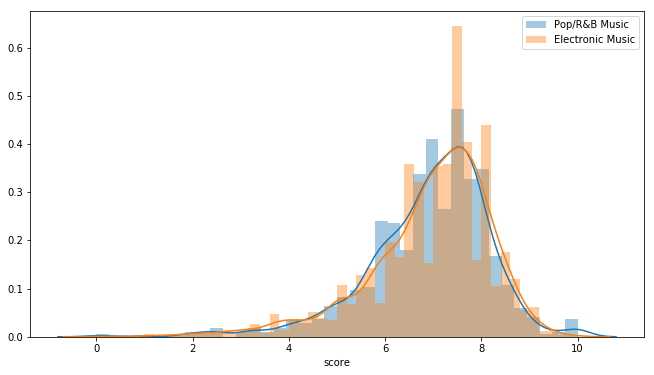

In [25]:
plt.figure(figsize=(11,6))
sns.distplot(pop_df['score'], label="Pop/R&B Music")
sns.distplot(elec_df['score'], label="Electronic Music");
plt.legend();

In [26]:
pop_df['score'].mean() - elec_df['score'].mean()

-0.015732026906106533

In [27]:
t_stat, p_val = ttest_ind(pop_df['score'],elec_df['score'])
print(f"T-Statistic: {t_stat}\nP-Value: {p_val}")

T-Statistic: -0.36421091026425517
P-Value: 0.7157164040794012


#### Finding Appropriate Sample Size

In [28]:
std_pop = pop_df['score'].std()
std_elec = elec_df['score'].std()
count_pop = len(pop_df)
count_elec = len(elec_df)
margin_of_error = 0.5

std_p = (( (count_pop-1)*(std_pop**2) ) + ( (count_elec-1)* (std_elec**2) )) / (count_pop + count_elec - 2)
samp_size_temp = 2*( ((1.96 * std_p)/margin_of_error)**2 )
samp_size_temp

87.64595381733686

Appropriate sample size must be greater than 87.6

In [29]:
samp_size = 90

#### Bootstrap Check

In [30]:
bootstrap_pop_sample = []
bootstrap_elec_sample = []

bootstrap_pop_sample_means = np.zeros(100)
bootstrap_elec_sample_means = np.zeros(100)

# boostrap_sample_means = np.zeros(1000)
# boostrap_sample_95pcts = np.zeros(1000)

for i in range(100):
    bootstrap_pop_samp = np.random.choice(pop_df['score'], size=samp_size, replace=True)
    bootstrap_elec_samp = np.random.choice(elec_df['score'], size=samp_size, replace=True)
    
    bootstrap_pop_sample.append(bootstrap_pop_samp)
    bootstrap_elec_sample.append(bootstrap_elec_samp)
    
    bootstrap_pop_sample_means[i] = bootstrap_pop_samp.mean()
    bootstrap_elec_sample_means[i] = bootstrap_elec_samp.mean()
#     bootstrap_sample_95pct = np.percent(a=boostrap_sample, q=95)
#     boostrap_sample_95pcts[i] = boostrap_sample_95pcts

print('Pop Sample Means Stdv: ', bootstrap_pop_sample_means.std())
print('Electric Sample Means Stdv: ', bootstrap_elec_sample_means.std())

print('Pop 2.5 Percentile: ', np.percentile(a=bootstrap_pop_sample_means, q=2.5))
print('Pop 97.5 Percentile: ', np.percentile(a=bootstrap_pop_sample_means, q=97.5))

print('Electronic 2.5 Percentile: ', np.percentile(a=bootstrap_elec_sample_means, q=2.5))
print('Electronic 97.5 Percentile: ', np.percentile(a=bootstrap_elec_sample_means, q=97.5))

# pop.mean()

Pop Sample Means Stdv:  0.14763645539961656
Electric Sample Means Stdv:  0.12744626512309853
Pop 2.5 Percentile:  6.661361111111111
Pop 97.5 Percentile:  7.214138888888889
Electronic 2.5 Percentile:  6.675611111111111
Electronic 97.5 Percentile:  7.16525


#### Summary: Hypothesis #1

Through our exploration, we found there to be very little variability between the rating of the two genres. We found a p-value of .716, which far exceeds our threshold of .05, telling us that we must accept our null hypothesis that there is not a statistically significant difference between the rating of pop/R&B and electronic albums.

In our further bootstrap test, sampling our data, we did not find significant variability in the performance of our two groups.

## Hypothesis Test #2
* Null: There is no statistically significant difference between self-released album ratings and all others. 
* Alternative: Self-released albums have a statistically significant decrease in ratings compared to other labels.

In [31]:
self_df = rl_df[rl_df['self-released'] == 1].copy()
other_df = rl_df[rl_df['self-released'] == 0].copy()

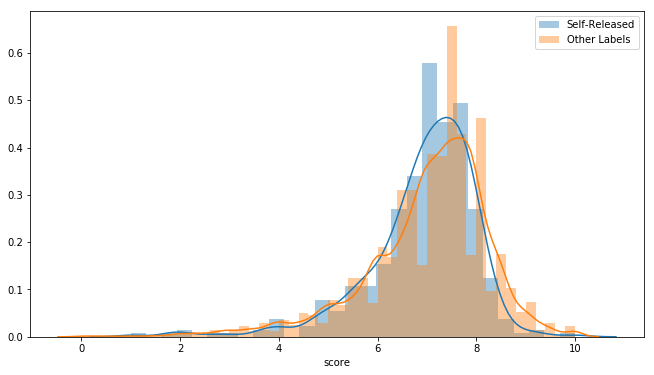

In [32]:
plt.figure(figsize=(11,6))
sns.distplot(self_df['score'], label="Self-Released")
sns.distplot(other_df['score'], label="Other Labels");
plt.legend();

In [33]:
print('Self-Released Mean Review: ', self_df['score'].mean())
print('Other Labels Mean Review: ', other_df['score'].mean())
print('Difference: ', self_df['score'].mean() - other_df['score'].mean())



Self-Released Mean Review:  6.918181818181823
Other Labels Mean Review:  7.0096126782108055
Difference:  -0.09143086002898215


In [34]:
t_stat, p_val = ttest_ind(self_df['score'],other_df['score'])
print(f"T-Statistic: {t_stat}\nP-Value: {p_val}")

T-Statistic: -1.4400160399176198
P-Value: 0.14988154041527244



* **Are there any reviewers who are harsher on specific genres over others, or just in general harsher? (reviews over??)** 
* **Are there words more commonly used in positive reviews, regardless of genre?**

## Possible Hypothesis:  Reviewer Comparisons
* Null Hypothesis: There is no statistical difference between reviewers with >200 album reviews and all others.
* Alternative: Reviews with >200 album reviews have a statistically significant different in their review scores. 

In [50]:
#genres_hot_df
author_reviews_df = reviews_df.copy()

author_counts = reviews_df['author'].value_counts()
author_dict = author_counts.to_dict()
author_reviews_df['author_review_count'] = author_reviews_df['author'].apply(lambda x: author_dict[x])
author_reviews_df['>200_reviews'] = author_reviews_df['author_review_count'].apply(lambda x: 1 if x >199 else 0)
author_reviews_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,author_review_count,>200_reviews
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,347,1
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,69,0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,4,0
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,41,0
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,51,0


In [78]:
author_to_drop = author_reviews_df[author_reviews_df['>200_reviews'] < 1]
author_reviews_df = author_reviews_df.drop(author_to_drop.index, axis=0)
author_reviews_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,author_review_count,>200_reviews
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,347,1
7,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,5,1,2017,250,1
8,22714,reflection,brian eno,http://pitchfork.com/reviews/albums/22714-refl...,7.7,0,andy beta,contributor,2017-01-04,2,4,1,2017,250,1
9,22724,filthy america its beautiful,the lox,http://pitchfork.com/reviews/albums/22724-filt...,5.3,0,ian cohen,contributor,2017-01-04,2,4,1,2017,699,1
10,22715,clear sounds/perfetta,harry bertoia,http://pitchfork.com/reviews/albums/22715-clea...,8.0,0,marc masters,contributor,2017-01-04,2,4,1,2017,312,1


In [83]:
authors_one_hot = pd.get_dummies(author_reviews_df['author'])
authors_one_hot.head().T
authors_hot_df = pd.concat([author_reviews_df, authors_one_hot], axis = 1)
authors_hot_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,...,mark richardson,matthew murphy,nate patrin,nick neyland,paul thompson,philip sherburne,rob mitchum,stephen m. deusner,stuart berman,tom breihan
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,...,0,0,1,0,0,0,0,0,0,0
7,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,...,0,0,0,0,0,0,0,0,0,0
8,22714,reflection,brian eno,http://pitchfork.com/reviews/albums/22714-refl...,7.7,0,andy beta,contributor,2017-01-04,2,...,0,0,0,0,0,0,0,0,0,0
9,22724,filthy america its beautiful,the lox,http://pitchfork.com/reviews/albums/22724-filt...,5.3,0,ian cohen,contributor,2017-01-04,2,...,0,0,0,0,0,0,0,0,0,0
10,22715,clear sounds/perfetta,harry bertoia,http://pitchfork.com/reviews/albums/22715-clea...,8.0,0,marc masters,contributor,2017-01-04,2,...,0,0,0,0,0,0,0,0,0,0


In [45]:
genre_count2 = genres_hot_df['reviewid'].value_counts()
genre_dict2 = genre_count2.to_dict()
genres_hot_df['genre_count'] = genres_hot_df['reviewid'].apply(lambda x: genre_dict2[x])
genres_hot_df.head()

,reviewid,genre,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,genre_count
0,22703,electronic,1,0,0,0,0,0,0,0,0,1
1,22721,metal,0,0,0,0,0,1,0,0,0,1
2,22659,rock,0,0,0,0,0,0,0,0,1,1
3,22661,rock,0,0,0,0,0,0,0,0,1,1
4,22725,electronic,1,0,0,0,0,0,0,0,0,1


In [85]:
#rg2 = review & genres v2
rg2_df = authors_hot_df.merge(genres_hot_df, left_on='reviewid', right_on='reviewid')
rg2_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,...,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,genre_count
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,...,1,0,0,0,0,0,0,0,0,1
1,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,...,1,0,0,0,0,0,0,0,0,1
2,22714,reflection,brian eno,http://pitchfork.com/reviews/albums/22714-refl...,7.7,0,andy beta,contributor,2017-01-04,2,...,0,1,0,0,0,0,0,0,0,1
3,22724,filthy america its beautiful,the lox,http://pitchfork.com/reviews/albums/22724-filt...,5.3,0,ian cohen,contributor,2017-01-04,2,...,0,0,0,0,0,0,0,1,0,1
4,22715,clear sounds/perfetta,harry bertoia,http://pitchfork.com/reviews/albums/22715-clea...,8.0,0,marc masters,contributor,2017-01-04,2,...,0,1,0,0,0,0,0,0,0,1


In [89]:
#Each genre for authors with >200 reviews:
rock_df = rg2_df[(rg2_df['rock'] == 1) & (rg2_df['>200_reviews'] == 1)]
elec_df = rg2_df[(rg2_df['electronic'] == 1) & (rg2_df['>200_reviews'] == 1)]
exper_df = rg2_df[(rg2_df['experimental'] == 1) & (rg2_df['>200_reviews'] == 1)]
rap_df = rg2_df[(rg2_df['rap'] == 1) & (rg2_df['>200_reviews'] == 1)]
pop_df = rg2_df[(rg2_df['pop/r&b'] == 1) & (rg2_df['>200_reviews'] == 1)]
metal_df = rg2_df[(rg2_df['metal'] == 1) & (rg2_df['>200_reviews'] == 1)]
folk_df = rg2_df[(rg2_df['folk/country'] == 1) & (rg2_df['>200_reviews'] == 1)]
jazz_df = rg2_df[(rg2_df['jazz'] == 1) & (rg2_df['>200_reviews'] == 1)]
global_df = rg2_df[(rg2_df['global'] == 1) & (rg2_df['>200_reviews'] == 1)]

In [92]:
#Each of the top 5 authors by each of the 9 categories:
#joe tangari .  ian cohen .  stephen m. deusner .  brian howe .  mark richardson . 
rock_df_joe = rock_df[(rock_df['author'] == 'joe tangari')]
rock_df_ian = rock_df[(rock_df['author'] == 'ian cohen')]
rock_df_stephen = rock_df[(rock_df['author'] == 'stephen m. deusner')]
rock_df_brian = rock_df[(rock_df['author'] == 'brian howe')]
rock_df_mark = rock_df[(rock_df['author'] == 'mark richardson')]

In [190]:
def compare_hist(df1, df2=None, df3=None, df4=None, df5=None):
    plt.figure(figsize=(11,6))
    sns.distplot(df1['score'], label='df1', hist=True, kde=True)
    sns.distplot(df2['score'], label='df2', hist=True, kde=True)
    sns.distplot(df3['score'], label='df3', hist=True, kde=True)
    sns.distplot(df4['score'], label='df4', hist=True, kde=True)
    sns.distplot(df5['score'], label='df5', hist=True, kde=True);
    return plt.legend()
#True False

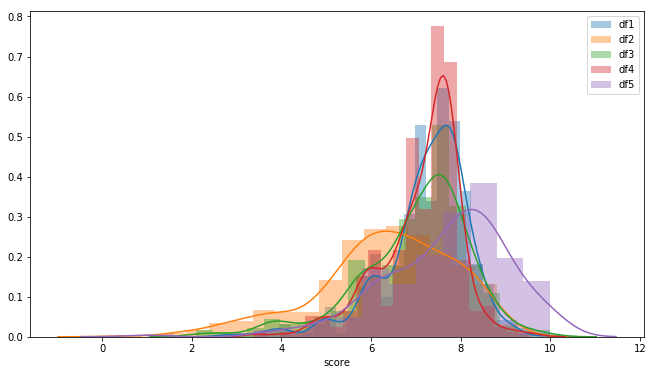

In [191]:
compare_hist(rock_df_joe, rock_df_ian, rock_df_stephen, rock_df_brian, rock_df_mark);

In [102]:
def output (df1, df2):
    print('df1 Review Mean: ', df1['score'].mean())
    print('df2 Review Mean: ', df2['score'].mean())
    print('Difference: ', df1['score'].mean() - df2['score'].mean())
    t_stat, p_val = ttest_ind(df1['score'],df2['score'])
    print(f"T-Statistic: {t_stat}\nP-Value: {p_val}")

In [103]:
output(rock_df_joe, rock_df_ian)

df1 Review Mean:  7.234166666666671
df2 Review Mean:  6.331521739130442
Difference:  0.9026449275362296
T-Statistic: 10.662012139533278
P-Value: 3.9363960042276256e-25


In [120]:
def sample_size(df1, df2, moe=.5):
    std_df1 = df1['score'].std()
    std_df2 = df2['score'].std()
    count_df1 = len(df1['score'])
    count_df2 = len(df2['score'])
    
    std_p = (( (count_df1-1)*(std_df1**2) ) + ( (count_df2-1)* (std_df2**2) )) / (count_df1 + count_df2 - 2)
    samp_size = 2*( ((1.96 * std_p)/moe)**2 )
    return samp_size

In [125]:
sample_size(rock_df_joe, rock_df_ian, moe=0.5)

87.10752089337349

In [131]:
def bootstrap(df1, df2, moe=0.5):
    bootstrap_df1_sample = []
    bootstrap_df2_sample = []

    bootstrap_df1_sample_means = np.zeros(100)
    bootstrap_df2_sample_means = np.zeros(100)

    for i in range(100):
        bootstrap_df1_samp = np.random.choice(df1['score'], size=int(sample_size(df1, df2, moe)), replace=True)
        bootstrap_df2_samp = np.random.choice(df2['score'], size=int(sample_size(df1, df2, moe)), replace=True)
    
        bootstrap_df1_sample.append(bootstrap_df1_samp)
        bootstrap_df2_sample.append(bootstrap_df2_samp)
    
        bootstrap_df1_sample_means[i] = bootstrap_df1_samp.mean()
        bootstrap_df2_sample_means[i] = bootstrap_df2_samp.mean()

    print('df1 Means Stdv: ', bootstrap_df1_sample_means.std())
    print('df2 Means Stdv: ', bootstrap_df2_sample_means.std())

    print('df1 2.5 Percentile: ', np.percentile(a=bootstrap_df1_sample_means, q=2.5))
    print('df1 97.5 Percentile: ', np.percentile(a=bootstrap_df1_sample_means, q=97.5))

    print('df2 2.5 Percentile: ', np.percentile(a=bootstrap_df2_sample_means, q=2.5))
    print('df2 97.5 Percentile: ', np.percentile(a=bootstrap_df2_sample_means, q=97.5))


In [193]:
bootstrap(rock_df_mark, rock_df_ian, moe=.5)

df1 Means Stdv:  0.121239429429734
df2 Means Stdv:  0.12031460940856113
df1 2.5 Percentile:  7.428411949685534
df1 97.5 Percentile:  7.885188679245282
df2 2.5 Percentile:  6.103553459119496
df2 97.5 Percentile:  6.542688679245282
